In [0]:

from os import listdir
import matplotlib.pyplot as  plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
!pip install PyDrive
!pip install Keras==2.3.1

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '1JxXOU58kxb3RkuGmYCY-jhpxp_YjWOw9'})
download.GetContentFile('color.zip')

download = drive.CreateFile({'id':'1qXmduQdH1598my8gaBsEDVoSczBQ5GKe'})
download.GetContentFile('weights-improvement-70-0.97.hdf5')

download = drive.CreateFile({'id':'1j1GTkIh-Yw9PqfeUwRIZJn52WXKuUmqV'})
download.GetContentFile('model.json')

In [22]:
!unzip color.zip

Archive:  color.zip
replace color/Grape/Grape___Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: color/Grape/Grape___Black_rot/00090b0f-c140-4e77-8d20-d39f67b75fcc___FAM_B.Rot 0376.JPG  
  inflating: color/Grape/Grape___Black_rot/003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.Rot 3184.JPG  
  inflating: color/Grape/Grape___Black_rot/004175d8-dc74-4285-8401-3cc9565730bb___FAM_B.Rot 0626.JPG  
  inflating: color/Grape/Grape___Black_rot/006efc68-9e46-4168-921c-10ef8065702c___FAM_B.Rot 3470.JPG  
  inflating: color/Grape/Grape___Black_rot/00905d40-bddf-460e-b348-1dbb6a34653b___FAM_B.Rot 0664.JPG  
  inflating: color/Grape/Grape___Black_rot/0093ee81-2439-414c-bfb5-a5b6cd6aea72___FAM_B.Rot 3429.JPG  
  inflating: color/Grape/Grape___Black_rot/00cab05d-e87b-4cf6-87d8-284f3ec99626___FAM_B.Rot 3244.JPG  
  inflating: color/Grape/Grape___Black_rot/00cff577-afd4-4e36-ac9c-a52aa6ae5949___FAM_B.Rot 0508.JPG  
  inflating: color/

In [0]:
def convert_image_to_array(image_dir):
    '''Transform a picture into an array'''

    default_image_size = tuple((256, 256))
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [24]:
directory_root = '/content/color'
image_list, label_list = [], []
image_size = 0
images_processed = 400

try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_folder in root_dir:  # get the plant folders name in the root directory
        plant_disease_folder_list = listdir(
            f"{directory_root}/{plant_folder}")

        for plant_disease_folder in plant_disease_folder_list:  # get the disease folder name
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(
                f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            # transformation of images into np arrays
            # specify the number of images loaded per folder
            for image in plant_disease_image_list[:images_processed]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if (image_directory.endswith(".jpg") == True) or (image_directory.endswith(".JPG") == True):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error : {e}")

image_size = len(image_list)
print(f'{len(image_list)} images have been processed!')


[INFO] Loading images ...
[INFO] Processing Pepper_bell___Bacterial_spot ...
[INFO] Processing Pepper_bell___healthy ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Image loading completed
5172 images have been processed!


In [25]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)
np_image_list = np.array(image_list, dtype=np.float16) / 225.0   # preprocessing the images

print("[INFO] Spliting data to train, test")

['Grape___Black_rot' 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Pepper_bell___Bacterial_spot' 'Pepper_bell___healthy'
 'Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Septoria_leaf_spot' 'Tomato___Target_Spot'
 'Tomato___Tomato_mosaic_virus' 'Tomato___healthy']
[INFO] Spliting data to train, test


In [0]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list,image_labels, test_size=0.2, random_state=42)

Loaded model from disk
[ 3  0  3 ... 10  7  2]
[ 3  0  3 ... 10  7  2]


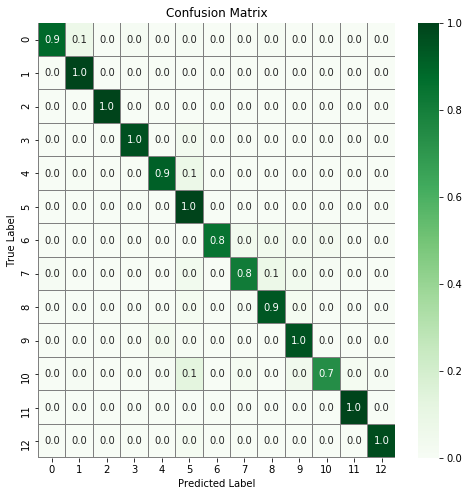

In [27]:
# load json and create model
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/content/weights-improvement-70-0.97.hdf5')
print("Loaded model from disk")

Y_pred = loaded_model.predict(x_test)
Y_true = y_test


Y_pred = loaded_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
print(Y_pred_classes)
Y_true = np.argmax(y_test,axis = 1)
print(Y_true)
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()